In [14]:
import os
import cv2
import skimage
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [15]:
BASE_DIR = r"C:\Users\Nived\Downloads\archive (1)\chest_xray"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# DEBUG CHECK (DO THIS ONCE)
print("Train dir exists:", os.path.exists(TRAIN_DIR))
print("Train classes:", os.listdir(TRAIN_DIR))

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

print("Class Mapping:", train_generator.class_indices)

Train dir exists: True
Train classes: ['NORMAL', 'PNEUMONIA']
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class Mapping: {'NORMAL': 0, 'PNEUMONIA': 1}


In [20]:
labels = ['PNEUMONIA','NORMAL']
img_size = 128
def get_data(data_dir):
    data = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img_arr is None:
                    continue

                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])

            except Exception as e:
                print(e)

    return np.array(data, dtype=object)



In [21]:
train = get_data(r"C:\Users\Nived\Downloads\archive (1)\chest_xray\train")
test = get_data(r"C:\Users\Nived\Downloads\archive (1)\chest_xray\test")
val = get_data(r"C:\Users\Nived\Downloads\archive (1)\chest_xray\val")

In [22]:
print("Train samples:", len(train))
print("Test samples:", len(test))
print("Val samples:", len(val))

print("Sample image shape:", train[0][0].shape)
print("Sample label:", train[0][1])

Train samples: 5216
Test samples: 624
Val samples: 16
Sample image shape: (128, 128)
Sample label: 0


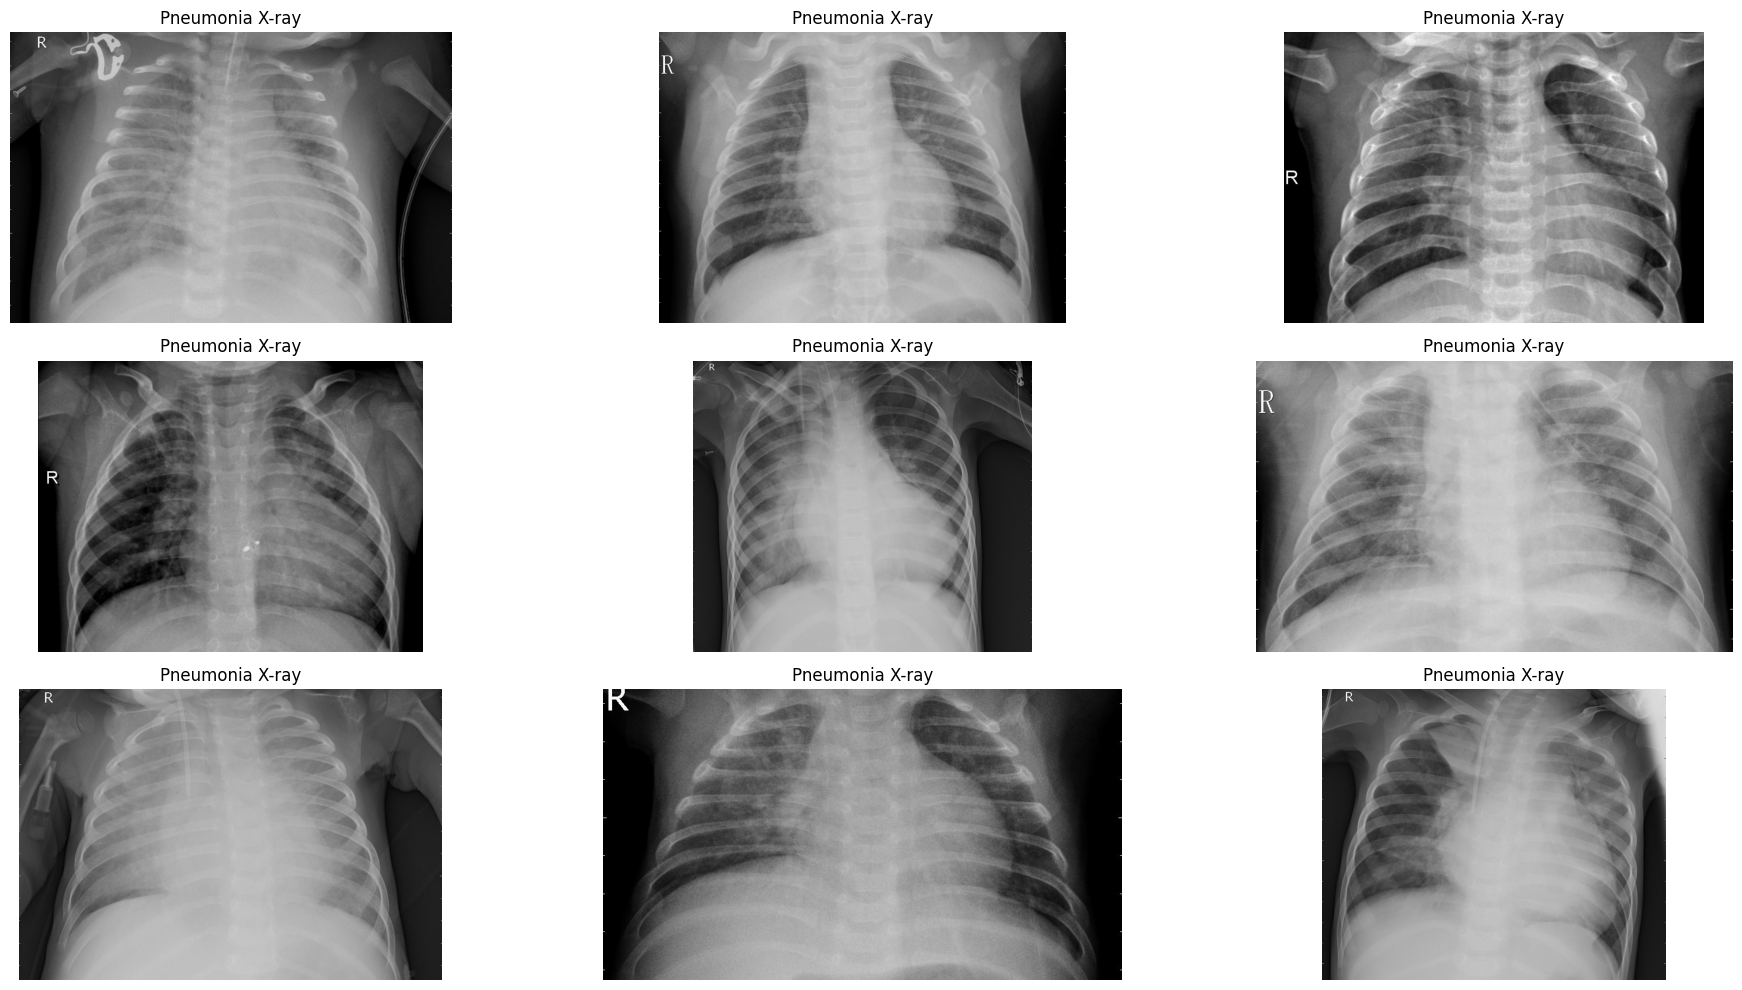

In [23]:
penumonia_dir = r"C:\Users\Nived\Downloads\archive (1)\chest_xray\train\PNEUMONIA"
pneumonia = os.listdir(penumonia_dir)

plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(penumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")

plt.tight_layout()

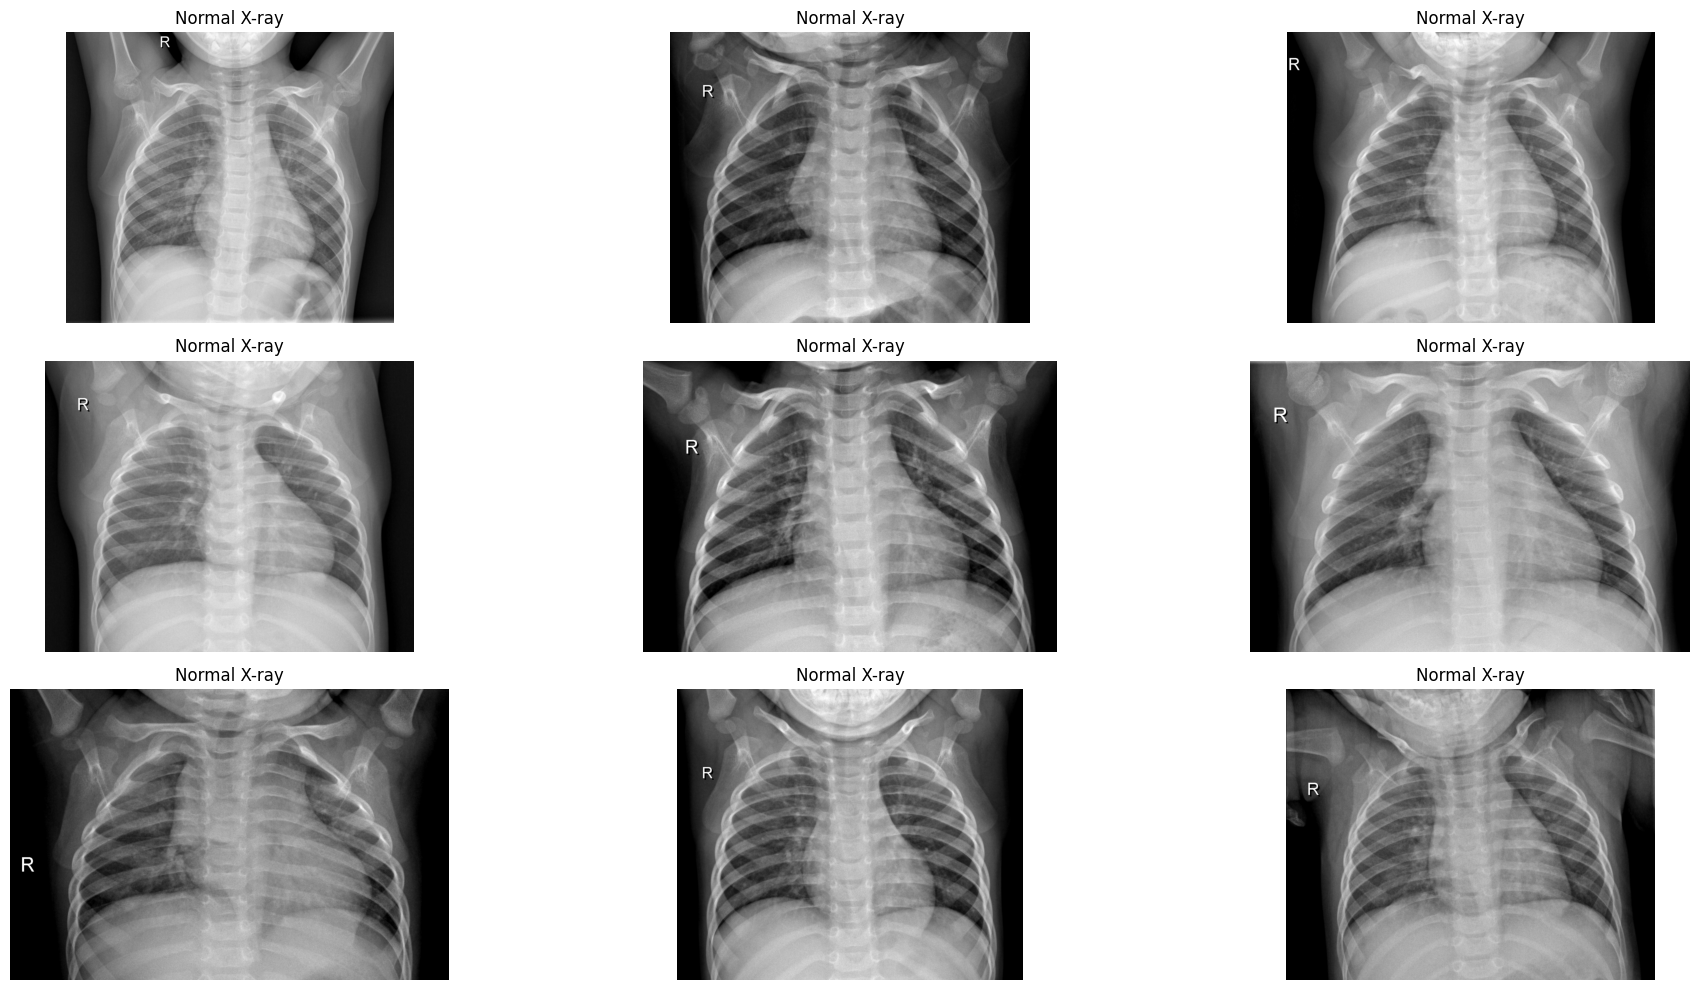

In [24]:
normal_dir = r"C:\Users\Nived\Downloads\archive (1)\chest_xray\train\NORMAL"
normal = os.listdir(normal_dir)

plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")

plt.tight_layout()

<Axes: xlabel='count'>

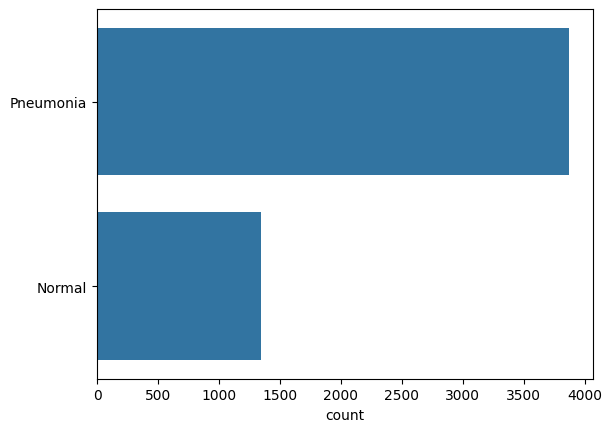

In [25]:
listx = []
for i in train:
    if(i[1] == 0):
        listx.append("Pneumonia")
    else:
        listx.append("Normal")
sns.countplot(listx)

In [28]:
train_datagen = ImageDataGenerator(
    rescale =1/255,
    horizontal_flip=0.4,
    vertical_flip=0.4,
    rotation_range=40,
    shear_range=0.2,
    width_shift_range=0.4,
    height_shift_range=0.4,
    fill_mode="nearest"
)
valid_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

In [29]:
train_generator = train_datagen.flow_from_directory(r"C:\Users\Nived\Downloads\archive (1)\chest_xray\train",
                                                   batch_size=32,
                                                   target_size=(128,128),
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   seed=42,
                                                   color_mode='rgb')
valid_generator = valid_datagen.flow_from_directory(r"C:\Users\Nived\Downloads\archive (1)\chest_xray\val",
                                                   batch_size=32,
                                                   target_size=(128,128),
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   seed=42,
                                                   color_mode='rgb')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [37]:
class_labels=train_generator.class_indices
print(class_labels)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [38]:
class_name={value:key for (key,value) in class_labels.items()}
print(class_name)

{0: 'NORMAL', 1: 'PNEUMONIA'}


In [39]:
# VGG19 CNN Architecture

In [40]:
base_model = VGG19(input_shape=(128,128,3),
                  include_top=False,
                  weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
flat = Flatten()(x)

class1=Dense(4608, activation='relu')(flat)
dropout=Dropout(0.2)(class1)
class2=Dense(1152, activation='relu')(dropout)
output=Dense(2,activation='softmax')(class2)

model_01=Model(base_model.inputs,output)
model_01.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [43]:
filepath='model.h5'

ES=EarlyStopping(monitor="val_loss", verbose=1, mode='min', patience=4)
CP=ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False, mode="auto", save_freq="epoch")
LRR=ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)
SGD=SGD(learning_rate=0.0001, decay=1e-6, momentum=0.00001, nesterov=True)

model_01.compile(loss="categorical_crossentropy", optimizer=SGD, metrics=['accuracy'])

In [45]:
history_01 = model_01.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=1,
    callbacks=[ES, CP, LRR],
    validation_data=valid_generator
)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5607 - loss: 0.6870

50/50 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - accuracy: 0.6719 - loss: 0.6233 - val_accuracy: 0.5000 - val_loss: 0.8056 - learning_rate: 1.0000e-04


In [47]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_01.save(filepath = "model_weights/vgg19_model_01.h5", overwrite=True)

In [48]:
test_generator = test_datagen.flow_from_directory(
    r"C:\Users\Nived\Downloads\archive (1)\chest_xray\test",
    batch_size=32,
    target_size=(128,128),
    class_mode='categorical',
    shuffle=True,
    seed=42,
    color_mode='rgb'
)

Found 624 images belonging to 2 classes.


In [49]:
model_01.load_weights("model_weights/vgg19_model_01.h5")

vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 0.8056
20/20 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.6250 - loss: 0.6782


In [50]:
print(f"Validation Loss: {vgg_val_eval_01[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_01[1]}")
print(f"Test Loss: {vgg_test_eval_01[0]}")
print(f"Test Accuarcy: {vgg_test_eval_01[1]}")

Validation Loss: 0.8055894374847412
Validation Accuarcy: 0.5
Test Loss: 0.6782053709030151
Test Accuarcy: 0.625


In [51]:
# Unfreezing and fine tuning the entire network

In [52]:
base_model=VGG19(include_top=False, input_shape=(128,128,3))

x=base_model.output
flat=Flatten()(x)

class_1=Dense(4608, activation='relu')(flat)
droput=Dropout(0.2)(class_1)
class_2=Dense(1152, activation='relu')(dropout)
output=Dense(2, activation='softmax')(class_2)

model_03=Model(base_model.inputs, output)
model_03.load_weights("model_weights/vgg19_model_01.h5")

print(model_03.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 128, 128, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 128, 128, 64)      │          36,928 │ block1_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_pool (MaxPooling2D)    │ (None, 64, 64, 64)        │               0 │ block1_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv1 (Conv2D)         │ (None, 64, 64, 128)       │          73,856 │ block1_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv2 (Conv2D)         │ (None, 64, 64, 128)       │         147,584 │ block2_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 32, 32, 128)       │               0 │ block2_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv1 (Conv2D)         │ (None, 32, 32, 256)       │         295,168 │ block2_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv2 (Conv2D)         │ (None, 32, 32, 256)       │         590,080 │ block3_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv3 (Conv2D)         │ (None, 32, 32, 256)       │         590,080 │ block3_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv4 (Conv2D)         │ (None, 32, 32, 256)       │         590,080 │ block3_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_pool (MaxPooling2D)    │ (None, 16, 16, 256)       │               0 │ block3_conv4[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv1 (Conv2D)         │ (None, 16, 16, 512)       │       1,180,160 │ block3_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv2 (Conv2D)         │ (None, 16, 16, 512)       │       2,359,808 │ block4_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv3 (Conv2D)         │ (None, 16, 16, 512)       │       2,359,808 │ block4_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv4 (Conv2D)         │ (None, 16, 16, 512)       │       2,359,808 │ block4_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_pool (MaxPooling2D)    │ (None, 8, 8, 512)         │               0 │ block4_conv4[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

None


In [58]:
from tensorflow.keras.optimizers import SGD as KerasSGD

sgd = KerasSGD(
    learning_rate=0.0001,
    momentum=0.00001,
    nesterov=True
)

model_03.compile(
    optimizer=sgd,
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [59]:
history_03 = model_02.fit(train_generator, 
            steps_per_epoch=100,
            epochs=1, 
            callbacks=[ES, CP, LRR],
            validation_data=valid_generator)

NameError: name 'model_02' is not defined